In [1]:
# C)Mostafa Amin-Naji, PhD student, Techinical University of Denmark
# My Website: www.AminNaji.com
# My Email: Mamna@dtu.dk, Mostafa.Amin.Naji@Gmail.com

# PLEASE CITE THE BELOW PAPER IF YOU USE THIS CODE


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import sys
import os
import random
import glob
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import PIL.ImageOps 
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.cm as cm
use_gpu = torch.cuda.is_available()
import imageio
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [3]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [4]:
use_gpu

True

In [5]:
DATA_DIR = "/data/userdata2/mamna/Deep_Learning_DTU/project/cifar10/focus&unfocus/"

trn_dir = f'{DATA_DIR}/train'
tst_dir = f'{DATA_DIR}/test'

sz = 32
batch_size = 64

In [6]:
images = [f for f in glob(f'{trn_dir}/*/*.tif')]   # training images
 

num_images = len(images)
avg_width, avg_height = 0.0, 0.0
for img_fname in tqdm(images, desc='Gathering statistics'):
    w, h = Image.open(img_fname).size
    avg_width += w
    avg_height += h
    
avg_width /= num_images
avg_height /= num_images

print('Average width: {:.2f}, Average height: {:.2f}'.format(avg_width, avg_height))


Gathering statistics: 100%|███████████████| 5000/5000 [00:01<00:00, 2866.71it/s]

Average width: 32.00, Average height: 64.00


In [7]:
mean = np.array([0., 0., 0.])
std = np.array([0., 0., 0.])

for img_fname in tqdm(images, desc='Gathering statistics'):
    img = np.array(Image.open(img_fname).convert('RGB'))
    mean += np.mean(img, axis=(0, 1))
    std += np.std(img, axis=(0, 1))

mean /= num_images
std /= num_images

print('Mean:', mean / 255.0)
print('Std:', std / 255.0)

Gathering statistics: 100%|███████████████| 5000/5000 [00:04<00:00, 1244.20it/s]

Mean: [0.48153569 0.48153569 0.48153569]
Std: [0.17723709 0.17723709 0.17723709]


In [8]:
os.listdir(DATA_DIR)

['train', 'test']

In [9]:
trn_fnames = glob(f'{trn_dir}/*/*.tif')
trn_fnames[:3]

['/data/userdata2/mamna/Deep_Learning_DTU/project/cifar10/focus&unfocus//train/focus_unfocus/sharp_blur_ver1_1.tif',
 '/data/userdata2/mamna/Deep_Learning_DTU/project/cifar10/focus&unfocus//train/focus_unfocus/sharp_blur_ver1_2.tif',
 '/data/userdata2/mamna/Deep_Learning_DTU/project/cifar10/focus&unfocus//train/focus_unfocus/sharp_blur_ver1_3.tif']

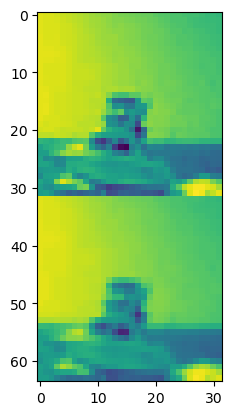

In [10]:
img = plt.imread(trn_fnames[100])
plt.imshow(img);

In [11]:
train_ds = datasets.ImageFolder(trn_dir)

In [12]:
# sz=64

In [13]:
tfms = transforms.Compose([
    transforms.Grayscale(),
#     transforms.Resize((sz, sz//2)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.48], [0.18]),
    
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
test_ds = datasets.ImageFolder(tst_dir, transform=tfms)


In [14]:
len(train_ds), len(test_ds)

(5000, 1800)

In [15]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=0)

In [16]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

In [17]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1, inplace=True),
        )
        
        self.conv1_4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.1, inplace=True),
        )
        
        

        self.fc1 = nn.Linear(1024, 16)
        self.fc2 = nn.Linear(32, 2, bias=False)
        
        
        
        self.rnn_1 = GRU(32, 16, batch_first = True)
 

        
        
    def forward(self, x, y):
        features = []
        outx = self.conv1_1(x)
        outx = self.conv1_2(outx)
        outx = self.conv1_3(outx)
        outx = self.conv1_4(outx)
        outx = outx.reshape(outx.size(0), -1)
        outx = self.fc1(outx)
        
        
        features.append(outx)


        outy = self.rnn_1(y)
        
        outy=outy[0]
        
        features.append(outy[:,0,:])
        
        
        features_final = torch.cat(features, dim=1)
            
             
        out = self.fc2(features_final)
           
        return out

In [18]:
model = Net()

if use_gpu:
    
    model = model.cuda()
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

In [19]:
model

DataParallel(
  (module): Net(
    (conv1_1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv1_2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (conv1_3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

In [20]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [21]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [23]:
a = time.time()
num_epochs = 500
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
  
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        inputs1=inputs
        
        inputs_SVD=torch.linalg.svdvals(inputs[:,:,:32,:])
        
        inputs_SVD = to_var(inputs_SVD)
         
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs1, inputs_SVD)

        # loss
        loss = criterion(outputs, targets)
        losses += [loss.item()]


        # backward pass
        loss.backward()

        
        # update parameters
        optimizer.step()

        
        # report
        if (i + 1) % 40 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))
            
b = time.time()
print('Total Time of Training {:.1000}s'.format(b - a))

Epoch [ 1/500], Step [ 40/ 78], Loss: 0.3764
Epoch [ 2/500], Step [ 40/ 78], Loss: 0.1425
Epoch [ 3/500], Step [ 40/ 78], Loss: 0.0884
Epoch [ 4/500], Step [ 40/ 78], Loss: 0.0559
Epoch [ 5/500], Step [ 40/ 78], Loss: 0.0579
Epoch [ 6/500], Step [ 40/ 78], Loss: 0.0315
Epoch [ 7/500], Step [ 40/ 78], Loss: 0.0357
Epoch [ 8/500], Step [ 40/ 78], Loss: 0.0251
Epoch [ 9/500], Step [ 40/ 78], Loss: 0.0311
Epoch [10/500], Step [ 40/ 78], Loss: 0.0199
Epoch [11/500], Step [ 40/ 78], Loss: 0.0148
Epoch [12/500], Step [ 40/ 78], Loss: 0.0207
Epoch [13/500], Step [ 40/ 78], Loss: 0.0189
Epoch [14/500], Step [ 40/ 78], Loss: 0.0233
Epoch [15/500], Step [ 40/ 78], Loss: 0.0053
Epoch [16/500], Step [ 40/ 78], Loss: 0.0111
Epoch [17/500], Step [ 40/ 78], Loss: 0.0076
Epoch [18/500], Step [ 40/ 78], Loss: 0.0146
Epoch [19/500], Step [ 40/ 78], Loss: 0.0117
Epoch [20/500], Step [ 40/ 78], Loss: 0.0095
Epoch [21/500], Step [ 40/ 78], Loss: 0.0116
Epoch [22/500], Step [ 40/ 78], Loss: 0.0073
Epoch [23/

Epoch [182/500], Step [ 40/ 78], Loss: 0.0002
Epoch [183/500], Step [ 40/ 78], Loss: 0.0002
Epoch [184/500], Step [ 40/ 78], Loss: 0.0009
Epoch [185/500], Step [ 40/ 78], Loss: 0.0002
Epoch [186/500], Step [ 40/ 78], Loss: 0.0003
Epoch [187/500], Step [ 40/ 78], Loss: 0.0000
Epoch [188/500], Step [ 40/ 78], Loss: 0.0007
Epoch [189/500], Step [ 40/ 78], Loss: 0.0002
Epoch [190/500], Step [ 40/ 78], Loss: 0.0030
Epoch [191/500], Step [ 40/ 78], Loss: 0.0005
Epoch [192/500], Step [ 40/ 78], Loss: 0.0014
Epoch [193/500], Step [ 40/ 78], Loss: 0.0004
Epoch [194/500], Step [ 40/ 78], Loss: 0.0006
Epoch [195/500], Step [ 40/ 78], Loss: 0.0006
Epoch [196/500], Step [ 40/ 78], Loss: 0.0005
Epoch [197/500], Step [ 40/ 78], Loss: 0.0020
Epoch [198/500], Step [ 40/ 78], Loss: 0.0004
Epoch [199/500], Step [ 40/ 78], Loss: 0.0030
Epoch [200/500], Step [ 40/ 78], Loss: 0.0003
Epoch [201/500], Step [ 40/ 78], Loss: 0.0004
Epoch [202/500], Step [ 40/ 78], Loss: 0.0002
Epoch [203/500], Step [ 40/ 78], L

Epoch [361/500], Step [ 40/ 78], Loss: 0.0010
Epoch [362/500], Step [ 40/ 78], Loss: 0.0000
Epoch [363/500], Step [ 40/ 78], Loss: 0.0013
Epoch [364/500], Step [ 40/ 78], Loss: 0.0002
Epoch [365/500], Step [ 40/ 78], Loss: 0.0002
Epoch [366/500], Step [ 40/ 78], Loss: 0.0001
Epoch [367/500], Step [ 40/ 78], Loss: 0.0003
Epoch [368/500], Step [ 40/ 78], Loss: 0.0000
Epoch [369/500], Step [ 40/ 78], Loss: 0.0003
Epoch [370/500], Step [ 40/ 78], Loss: 0.0001
Epoch [371/500], Step [ 40/ 78], Loss: 0.0012
Epoch [372/500], Step [ 40/ 78], Loss: 0.0003
Epoch [373/500], Step [ 40/ 78], Loss: 0.0000
Epoch [374/500], Step [ 40/ 78], Loss: 0.0002
Epoch [375/500], Step [ 40/ 78], Loss: 0.0002
Epoch [376/500], Step [ 40/ 78], Loss: 0.0005
Epoch [377/500], Step [ 40/ 78], Loss: 0.0000
Epoch [378/500], Step [ 40/ 78], Loss: 0.0000
Epoch [379/500], Step [ 40/ 78], Loss: 0.0005
Epoch [380/500], Step [ 40/ 78], Loss: 0.0002
Epoch [381/500], Step [ 40/ 78], Loss: 0.0001
Epoch [382/500], Step [ 40/ 78], L

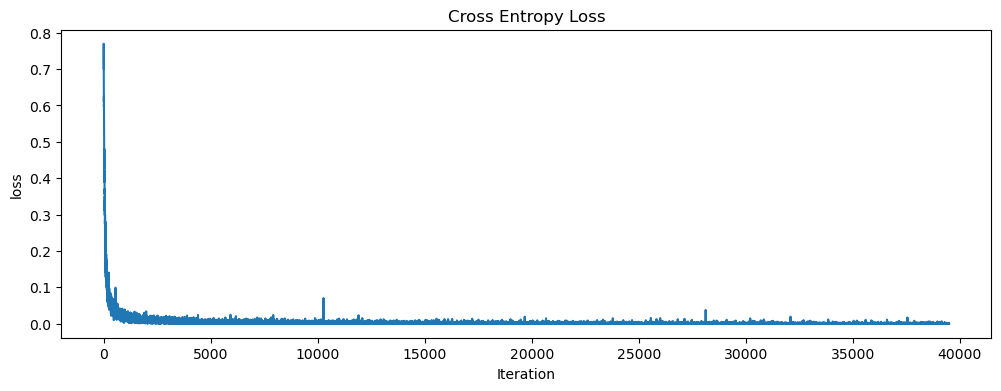

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

In [25]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
#         targets = to_var(targets)

        inputs_SVD=torch.linalg.svdvals(inputs[:,:,:32,:])
        inputs_SVD = to_var(inputs_SVD)
        outputs = model(inputs, inputs_SVD)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
        
    zz=len(dataloader.dataset)
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))
    print('corrects: {:.2f}'.format(corrects))
    print('Toatal: {:.2f}'.format(zz))
    

In [26]:
evaluate_model(model, train_dl)

/tmp/ipykernel_343514/2390227020.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 100.00
corrects: 5000.00
Toatal: 5000.00


In [27]:
evaluate_model(model, test_dl)

/tmp/ipykernel_343514/2390227020.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 100.00
corrects: 1800.00
Toatal: 1800.00


In [43]:
torch.save(model.state_dict(), 'DL_network_wights.pth')


In [22]:
model.load_state_dict(torch.load('DL_network_wights.pth'))

<All keys matched successfully>

100%|█████████████████████████████████████████| 163/163 [01:34<00:00,  1.73it/s]


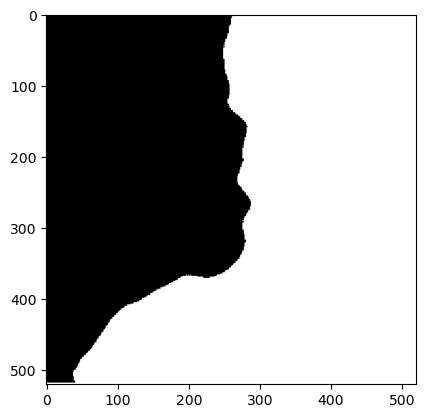

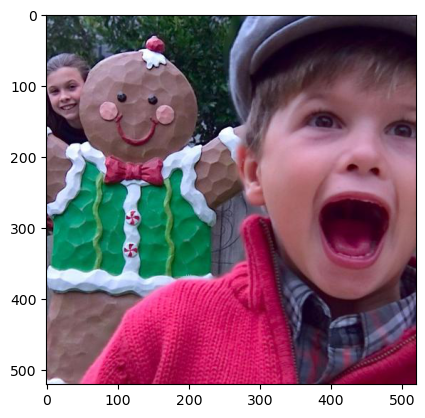

In [23]:
original_path1= './LytroDataset/lytro-03-A.jpg'  
original_path2= './LytroDataset/lytro-03-B.jpg'

tfms1 = transforms.Compose([
    transforms.Resize((64, 32)), 
    transforms.ToTensor(), 
    transforms.Normalize([0.45 ], [0.1])
])


img1_org = Image.open(original_path1)
img2_org = Image.open(original_path2)
img1_org = np.asarray(img1_org)
img2_org = np.asarray(img2_org)
height=img1_org.shape[0]
width=img2_org.shape[1]

windows_size=32
# stride can be set as 2 or 4 or 8 based on the size of input images
# if width>= 500 and height>=500:
#     factor=1
#     stride=5
# else:
#     factor=2
#     stride=8
    
factor=1
stride=3
    
dim1=(width, height)
dim2 = (int(width*factor), int(height*factor))        
img1 = cv2.resize(img1_org, dim2, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2_org, dim2, interpolation = cv2.INTER_AREA)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)    
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)  

test_image1_1=img1_gray


test_image2_1=img2_gray



source1=img1
source2=img2

j=0

MAP=np.zeros([img1.shape[0], img1.shape[1]])

score1=0
score2=0
FUSED=np.zeros(test_image1_1.shape)

windowsize_r = windows_size-1
windowsize_c = windows_size-1

map1=np.zeros([img1.shape[0], img1.shape[1]])
map2=np.zeros([img2.shape[0], img2.shape[1]])

for r in tqdm(range(0,img1.shape[0] - windowsize_r, stride)):
    for c in range(0,img1.shape[1] - windowsize_c, stride):
        
        block_test1_1 = test_image1_1[r:r+windowsize_r+1,c:c+windowsize_c+1]

        block_test2_1 = test_image2_1[r:r+windowsize_r+1,c:c+windowsize_c+1]

 
        block1_1= np.concatenate((block_test1_1, block_test2_1), axis=0)
        block2_1= np.concatenate((block_test2_1, block_test1_1), axis=0)  
        block1_1 = Image.fromarray(block1_1, 'L')
        block2_1 = Image.fromarray(block2_1, 'L')

                 
        imout1_1=tfms1(block1_1)
        imout2_1=tfms1(block2_1)

        
        if use_gpu:
            imout1_1=to_var(imout1_1)
            imout2_1=to_var(imout2_1)

        
        imout1_1=(imout1_1)
        imout2_1=(imout2_1)

        
        
        inputs1_1 = imout1_1.unsqueeze(0)
        inputs2_1 = imout2_1.unsqueeze(0)


        model.eval()

        inputs1_SVD=torch.linalg.svdvals(inputs1_1[:,:,:32,:])
        inputs1_SVD = to_var(inputs1_SVD)
        
        outputs1 = model(inputs1_1, inputs1_SVD)
        _, predicted1 = torch.max(outputs1.data, 1)
        
        score1=predicted1.detach().cpu().numpy()

        model.eval()
        
        inputs2_SVD=torch.linalg.svdvals(inputs2_1[:,:,:32,:])
        inputs2_SVD = to_var(inputs2_SVD)
        
        outputs2 = model(inputs2_1, inputs2_SVD)
        _, predicted2 = torch.max(outputs2.data, 1)
        
        score2=predicted2.detach().cpu().numpy()
        
        map2[r:r+windowsize_r+1,c:c+windowsize_c+1] += 1
        
        if score1 <= score2:
            map1[r:r+windowsize_r+1,c:c+windowsize_c+1] += +1 
      
        else:
            map1[r:r+windowsize_r+1,c:c+windowsize_c+1] += -1
            
map1 = cv2.resize(map1, dim1, interpolation = cv2.INTER_AREA)
test_image1 = img1_org
test_image2 = img2_org
map3=np.zeros([img1_org.shape[0], img2_org.shape[1]])
FUSED=np.zeros(img1_org.shape)
for r in range(0,img1_org.shape[0], 1):
    for c in range(0,img1_org.shape[1], 1):   
        
        if map1[r,c] < 0:
            map3[r,c] =0
            FUSED[r,c]=img2_org[r,c]
            
        else:
            map3[r,c] =1
            FUSED[r,c]=img1_org[r,c]
            
FUSED_8=FUSED.astype(np.uint8)
plt.imshow(map3, cm.gray)
plt.show()
plt.imshow(FUSED_8)
plt.show()
imageio.imwrite('./results/lytro-07.tif', FUSED_8)
imageio.imwrite('./results/lytro-07.jpg', FUSED_8)

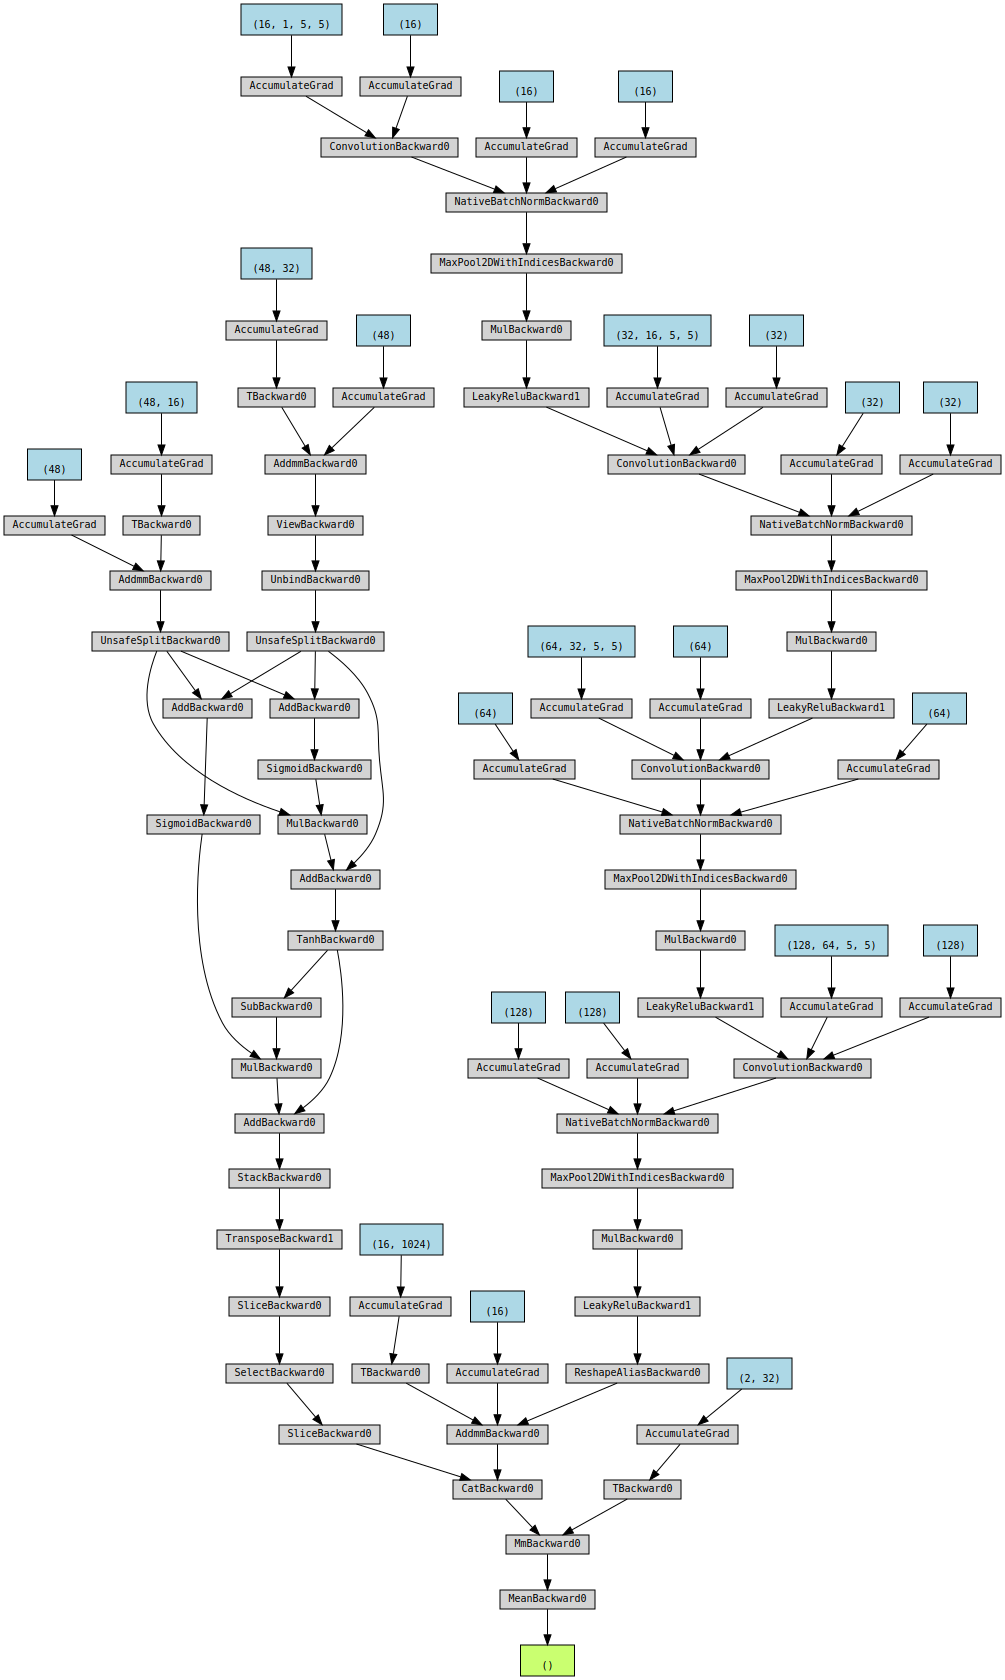

In [24]:
from torchviz import make_dot
X = torch.randn(64, 1, 32, 64)
XX = torch.randn(64, 1, 32)
model2 = Net()
y = model2(X, XX)
make_dot(y.mean(), params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")
make_dot(y.mean(), params=dict(list(model.named_parameters())))